# Load and Preprocess Enron Dataset #

### Load Enron Dataset ###

In [4]:
import os
import string
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import random
from sklearn.model_selection import train_test_split
import sys



NUM_ENRON_DATASETS = 6


# Define categories
categories = ['ham', 'spam']
num_categories = len(categories)

# Define dataset class
class EmailDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# Initialize variables
categories_to_emails = {'ham':[], 'spam':[]}
categories_to_num_emails_before_filtering = {'ham':0, 'spam':0}

for i in range(NUM_ENRON_DATASETS):
    data_dir = 'enron' + str(i+1)
    # Load data
    for category in categories:
        # Get list of files
        path = os.path.join(data_dir, category)
        files = os.listdir(path)

        for file in files:
            categories_to_num_emails_before_filtering[category] +=1
            
            # Read file
            with open(os.path.join(path, file), 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()

            # Remove punctuation
            text = text.translate(str.maketrans('', '', string.punctuation))
            # add to dictionary
            categories_to_emails[category].append(text)
    print("Processed " + str(i+1) + " Out of " + str(NUM_ENRON_DATASETS) + " Folders!")


print(len(categories_to_emails['ham']) , "ham and", len(categories_to_emails['spam']), "spam emails total")

combined_emails = categories_to_emails['ham'] + categories_to_emails['spam']
print("Min Email Word Count",min(len(email.split()) for email in combined_emails) , "Max Word Count", max(len(email.split()) for email in combined_emails))

Processed 1 Out of 6 Folders!
Processed 2 Out of 6 Folders!
Processed 3 Out of 6 Folders!
Processed 4 Out of 6 Folders!
Processed 5 Out of 6 Folders!
Processed 6 Out of 6 Folders!
16545 ham and 17171 spam emails total
Min Email Word Count 1 Max Word Count 37138


### Truncate and Balance the Data ###

In [5]:
MAX_EMAIL_LENGTH = 200

category_to_truncated_emails = {'ham':[], 'spam':[]}
# truncate emails
for category, emails in categories_to_emails.items():
    for email in emails:
        split_email = email.split()
        truncated_end_index = min(len(split_email), MAX_EMAIL_LENGTH)
        truncated_email = ' '.join(split_email[:truncated_end_index])
        category_to_truncated_emails[category].append(truncated_email)

categories_to_emails = category_to_truncated_emails
# Find the minimum length of the email lists in each category
min_len = min(len(email_list) for email_list in categories_to_emails.values())
print("Min Class Length", min_len)

# Create a new dictionary to store the randomly sampled emails
sampled_categories_to_emails = {'ham':[], 'spam':[]}

# Loop through the categories and the corresponding indices, and add the sampled emails to the new dictionary
for (category, email_list) in categories_to_emails.items():
    sample_indices = random.sample(range(len(email_list)), min_len)
    sampled_emails = [email_list[i] for i in sample_indices]
    sampled_categories_to_emails[category] = sampled_emails

print("After balancing,", len(sampled_categories_to_emails['ham']), "ham and", len(sampled_categories_to_emails['spam']), "spam emails total")

Min Class Length 16545
After balancing, 16545 ham and 16545 spam emails total


### Convert to list of emails and corresponding labels and shuffle ###

In [6]:
emails = sampled_categories_to_emails['ham'] + sampled_categories_to_emails['spam']

# Create a list of corresponding labels
labels = ['ham'] * len(sampled_categories_to_emails['ham']) + ['spam'] * len(sampled_categories_to_emails['spam'])

# Shuffle the emails and labels in unison
shuffled_indices = list(range(len(emails)))
random.shuffle(shuffled_indices)
emails = [emails[i] for i in shuffled_indices]
labels = [labels[i] for i in shuffled_indices]
print("First 3 emails:")
for i in range(3):
    print("--------------------------------------Email:", emails[i])
    print("Label:", labels[i])

First 3 emails:
--------------------------------------Email: Subject reduzca sus gastos telefonicos empresa lider mundial le permite utilizar su nueva tecnologia y llamar a todo el mundo gratis para mas informacion pinche aqui
Label: spam
--------------------------------------Email: Subject relief for earthquake victims in el salvador on saturday january 13 2001 an earthquake shook central america the earthquake which had a magnitude of 7 6 was centered off of el salvador s central coast the death toll is currently at 700 and the damage has been estimated at nearly 1 billion nearly half of the country s annual budget enron employees are encouraged to donate to relief efforts and to take advantage of our matching gift program to double the impact of your donation enron will match dollar for dollar every donation that you make up to 15 000 annually per employee listed below are a multitude of organizations that are offering aid to the victims of this earthquake to print a matching gift f

### Tokenize and pad sequences ###

In [7]:
# Tokenize text
word_to_idx = {}
idx_to_word = {}
for email in emails:
    for word in email.split():
        if word not in word_to_idx:
            idx = len(word_to_idx) + 1
            word_to_idx[word] = idx
            idx_to_word[idx] = word
vocab_size = len(word_to_idx)+1


# Convert text to sequence of indices
sequences = []
for email in emails:
    sequence = [word_to_idx[word] for word in email.split()]
    sequences.append(sequence)

# Pad sequences to be of equal length
max_len = max([len(seq) for seq in sequences])
padded_sequences = []
for seq in sequences:
    seq = torch.LongTensor(seq)
    padded_seq = torch.zeros(max_len, dtype=torch.long)
    padded_seq[:len(seq)] = seq
    padded_sequences.append(padded_seq)
    
# Convert labels to categorical
cat_labels = torch.tensor([categories.index(label) for label in labels], dtype=torch.long)




print("Vocab_Size:", vocab_size, "NumSpam:", "MaxSequenceLen:", max_len)
print(padded_sequences[10], cat_labels[10])

Vocab_Size: 121578 NumSpam: MaxSequenceLen: 200
tensor([  1,  42, 201, 188, 451, 594, 595,  84,  72, 596,  52,  73,  17, 597,
        598, 599,  76,  17, 600, 601, 602, 106,  46, 603,  46, 604, 605,  46,
        606, 550, 606,  38, 607,  46,  72, 608,  62,  63, 609, 122,  42, 610,
         60, 611, 612,  31, 613, 122,  42, 600, 106, 606,  62, 614,  76, 615,
         17, 616, 568,  46, 603,  46, 606,  52, 604, 605,  28, 187, 457,  72,
        596,  52,  73,  60, 617, 498, 618, 594, 595,  84, 137,  94, 138, 139,
        619,  31, 620, 621, 622,  42, 594, 595,  84,  43,  62,  17, 623,  46,
        624, 200, 625, 111, 626,  42, 627,  76,  42, 198, 628, 246,  94,  89,
        629,  17, 630, 631,  17, 632, 633,  42,  84,  38, 634,  46, 619, 110,
         60,  38, 635, 636, 637,  76,  42, 106, 229,  31,  42, 638,  93,  94,
         74, 639,  76, 626,  42, 640, 627, 111, 641,  42, 627,  76,  42, 642,
        643,  46,  87, 644, 645,  42, 198, 646,  74, 647,  76, 210, 648,  31,
        108, 216

### Define data loaders ###

In [8]:

train_percent = .6
test_percent = .2
validation_percent = .2

# Split data into train, test, and validation sets
train_data, test_val_data, train_labels, test_val_labels = train_test_split(padded_sequences, cat_labels, test_size=test_percent+validation_percent, stratify=cat_labels)
val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=test_percent/(test_percent+validation_percent), stratify=test_val_labels)


train_dataset = EmailDataset(train_data, train_labels)
test_dataset = EmailDataset(test_data, test_labels)
validation_dataset = EmailDataset(val_data, val_labels)


# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
print("Train Size:", len(train_dataset), "Test Size:", len(test_dataset), "Validation Size:", len(validation_dataset))

Train Size: 19854 Test Size: 6618 Validation Size: 6618


# Define Model #

In [9]:
import torch.nn.init as init


class WordLSTM(nn.ModuleList):
    def __init__(self, input_size, hidden_dim, LSTM_layers, device):
        super(WordLSTM, self).__init__()
        self.LSTM_layers = LSTM_layers
        self.hidden_dim = hidden_dim
        self.device = device

        
        self.embedding = nn.Embedding(input_size, hidden_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=LSTM_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=hidden_dim, out_features=257)
        self.fc2 = nn.Linear(257, 1)
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
        c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
        h = h.to(self.device)
        c = c.to(self.device)

        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        out = self.embedding(x)
        out, (hidden, cell) = self.lstm(out, (h,c))
        out = self.fc1(out[:,-1,:])
        out = torch.relu_(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out.squeeze()

#### Initialize Cuda if available ####

In [10]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
    #device = torch.device("cpu")
else:
    print("CUDA is not available.")
    print(torch.__version__)
    device = torch.device("cpu")

CUDA is available!
GPU: NVIDIA GeForce GTX 1080 Ti


# Initialize Model #

In [11]:
# Define hyperparameters
hidden_size = 128
num_layers = 2

# Initialize model
model = WordLSTM(vocab_size, hidden_size, num_layers, device)
#torch.cuda.empty_cache()
model.to(device)
print(model)
print(sum(p.numel() for p in model.parameters()))


WordLSTM(
  (0): Embedding(121578, 128, padding_idx=0)
  (1): LSTM(128, 128, num_layers=2, batch_first=True)
  (2): Linear(in_features=128, out_features=257, bias=True)
  (3): Linear(in_features=257, out_features=1, bias=True)
)
15859587


### Initialize Criterion, Optimizer, and Scheduler ###

In [12]:
import torch.optim as optim

learning_rate = 0.001


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)

# Train Model #

In [13]:
import sys
    
num_epochs = 20
# Train the model
train_loss_arr = []
val_loss_arr = []
prev_val_loss = sys.maxsize
for epoch in range(num_epochs):
    
    train_loss = 0
    
    # Train the model on the training set
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)


        # Forward pass
        outputs = model(inputs)
        
        
        loss = criterion(outputs.float(), labels.float())
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
       
        optimizer.step()
    
       
    train_loss /= len(train_loader)
    train_loss_arr.append(train_loss)
    
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            val_loss += loss.item()

        val_loss /= len(validation_loader)
        val_loss_arr.append(val_loss)
    scheduler.step(val_loss)
    cur_lr = [param_group['lr'] for param_group in optimizer.param_groups]
    print('Current learning rate:', cur_lr)
    # Print the average train and validation losses for this epoch
    print("Epoch {}/{} Train Loss: {:.4f} Validation Loss: {:.4f}".format(epoch+1, num_epochs, train_loss, val_loss))

Current learning rate: [0.001]
Epoch 1/20 Train Loss: 0.5523 Validation Loss: 0.6138
Current learning rate: [0.001]
Epoch 2/20 Train Loss: 0.4938 Validation Loss: 0.4624
Current learning rate: [0.001]
Epoch 3/20 Train Loss: 0.6177 Validation Loss: 0.6749
Current learning rate: [0.001]
Epoch 4/20 Train Loss: 0.6691 Validation Loss: 0.6572
Current learning rate: [0.001]
Epoch 5/20 Train Loss: 0.4408 Validation Loss: 0.0951
Current learning rate: [0.001]
Epoch 6/20 Train Loss: 0.0774 Validation Loss: 0.0667
Current learning rate: [0.001]
Epoch 7/20 Train Loss: 0.0308 Validation Loss: 0.0579
Current learning rate: [0.001]
Epoch 8/20 Train Loss: 0.0172 Validation Loss: 0.0565
Current learning rate: [0.001]
Epoch 9/20 Train Loss: 0.0092 Validation Loss: 0.0609
Current learning rate: [0.001]
Epoch 10/20 Train Loss: 0.0048 Validation Loss: 0.0669
Current learning rate: [0.0005]
Epoch 11/20 Train Loss: 0.0030 Validation Loss: 0.0837
Current learning rate: [0.0005]
Epoch 12/20 Train Loss: 0.0007

# Evaluate Model #

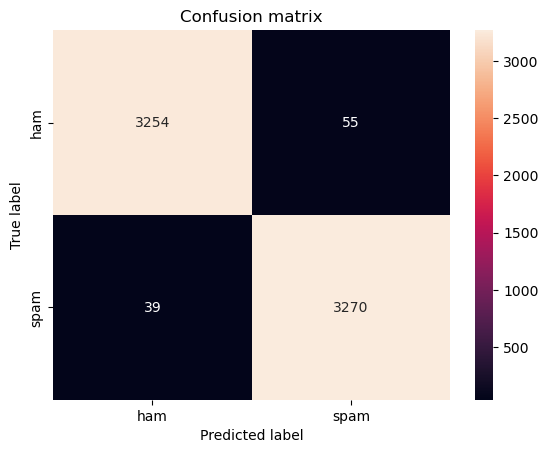

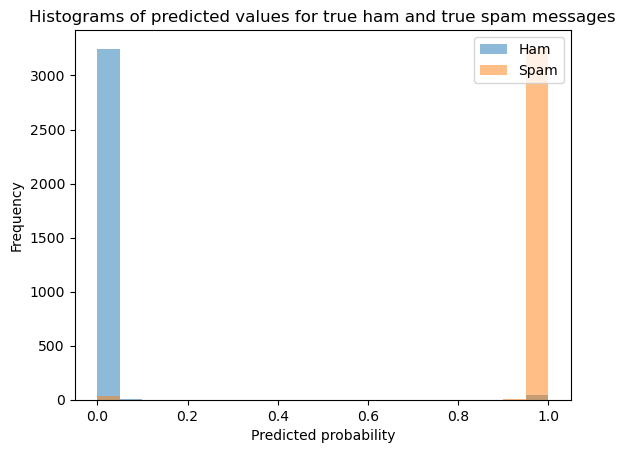

Accuracy: 0.9858
Precision: 0.9835
Recall: 0.9882
F1-score: 0.9858
ROC-AUC score: 0.9969


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def print_model_results(model, print_plots=True, print_extended_stats = True):
    model.eval()
    preds = []
    targets = []
    raw_outputs = []
    ham_preds = []
    spam_preds = []
    num_printed = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            # Forward pass
            outputs = model(inputs)
            #print(outputs)
            if(num_printed<2): 
                #print(outputs)
                num_printed+=1
            raw_outputs.append(outputs.cpu())
            preds.append((outputs>.5).cpu().long().numpy())
            targets.append(labels.cpu().numpy())
            for i, label in enumerate(labels):
                if label == 0:
                    ham_preds.append(outputs[i].cpu().numpy())
                else:
                    spam_preds.append(outputs[i].cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    raw_outputs = np.concatenate(raw_outputs)
    
    if(print_plots):
        cm = confusion_matrix(targets, preds)

        # Create heatmap with labeled rows and columns
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)

        # Add axis labels and title
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion matrix')

        # Show the plot
        plt.show()



         # show the plot

        # Create histograms of predicted values for true ham and true spam messages
        plt.hist(ham_preds, bins=20, alpha=0.5, label='Ham')
        plt.hist(spam_preds, bins=20, alpha=0.5, label='Spam')
        plt.legend(loc='upper right')
        plt.xlabel('Predicted probability')
        plt.ylabel('Frequency')
        plt.title('Histograms of predicted values for true ham and true spam messages')
        plt.show()
    
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    roc_auc = roc_auc_score(targets, raw_outputs)
    print("Accuracy: {:.4f}".format(acc))
    if(print_extended_stats):
        print("Precision: {:.4f}".format(prec))
        print("Recall: {:.4f}".format(rec))
        print("F1-score: {:.4f}".format(f1))
        print("ROC-AUC score: {:.4f}".format(roc_auc))
    
print_model_results(model)